# Task Scheduling with Luigi

![title](img/paper-airplanes-design.png)
https://www.teachthought.com/education/a-really-cool-database-for-paper-airplanes/

![title](img/luigi.png)
https://luigi.readthedocs.io/en/stable/

* Luigi is designed for pipelining tasks together
* Works well with long running batch tasks
* Works well with atomistic tasks
* Can be used to manage distributed tasks
* Works well with databases & [Hadoop](http://hadoop.apache.org/)

## Anatomy of a Luigi task

In [1]:
import os
import luigi
from plot import plot_airplane 

class Airplane(luigi.Task):
    """
    Create a plot of an airplane
    
    Methods
    --------
    requires()
        What prerequiste tasks does this need
    
    run()
        Running the code for the task
    
    output()
        Define output  that defines the task as complete
    """
    def requires(self):
        pass
    
    def run(self):
        plot_airplane(filename=os.path.join("img/plane.png"))
        
    def output(self):
        luigi.LocalTarget(os.path.join("img/plane.png"))
        

## Running A Luigi Task

DEBUG: Checking if Airplane() is complete
/home/nelse003/anaconda3/envs/luigi_tutorial/lib/python3.7/site-packages/luigi/worker.py:409: UserWarning: Task Airplane() without outputs has no custom complete() method
  is_complete = task.complete()
INFO: Informed scheduler that task   Airplane__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 22646] Worker Worker(salt=626932236, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) running   Airplane()


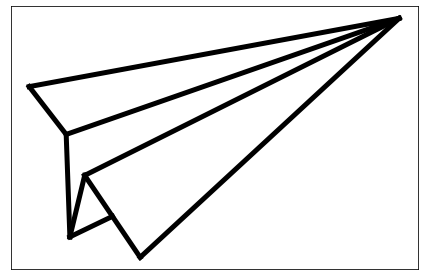

INFO: [pid 22646] Worker Worker(salt=626932236, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) done      Airplane()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   Airplane__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=626932236, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 ran successfully:
    - 1 Airplane()

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



True

In [2]:
luigi.build(
    [
       Airplane(), 
            ],
    local_scheduler=True
)

## Central task Scheduler

Luigi has a central scheduler which runs using as [daemon](https://en.wikipedia.org/wiki/Daemon_(computing))

Run `luigid` from activated conda env

By default availiable at [localhost:8082](http://localhost:8082/static/visualiser/index.html#)

DEBUG: Checking if Airplane() is complete
INFO: Informed scheduler that task   Airplane__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 22646] Worker Worker(salt=567071197, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) running   Airplane()


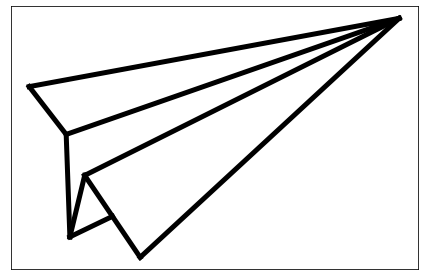

INFO: [pid 22646] Worker Worker(salt=567071197, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) done      Airplane()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   Airplane__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=567071197, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 ran successfully:
    - 1 Airplane()

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



True

In [3]:
luigi.build(
    [
       Airplane(), 
            ],
)

## Task Dependency

So far we have done one thing. 

Making task scheduling pretty pointless.

We need some tasks that depend on each other

In [4]:
import IPython
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

class AirplaneGallery(luigi.Task):
    """
    Create a plot of an airplane
    
    Methods
    --------
    requires()
        We need the airplane picture, and thus the Airplane task
    
    run()
        Display a gallery of airplanes
    
    output()
        Output that defines the task as complete
    """
    def requires(self):
        Airplane()
    
    def run(self):
        
        img = mpimg.imread("img/plane.png")
        
        store_scale = 3.0
        
        plt.figure(figsize=(20,10))
        gridspec.GridSpec(200,100)

        scales = [10,20,30,40]
            
        offset = 0
        for scale in scales:
            plt.subplot2grid((200,100),(0, offset), colspan=scale, rowspan=int(scale*1.5))
            plt.imshow(img)
            plt.axis('off')
            plt.title(scale)
            offset += scale 
     
        plt.savefig("img/gallery.png")
    
    def output(self):
        luigi.LocalTarget("img/gallery.png")

DEBUG: Checking if AirplaneGallery() is complete
/home/nelse003/anaconda3/envs/luigi_tutorial/lib/python3.7/site-packages/luigi/worker.py:409: UserWarning: Task AirplaneGallery() without outputs has no custom complete() method
  is_complete = task.complete()
INFO: Informed scheduler that task   AirplaneGallery__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 22646] Worker Worker(salt=321464686, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) running   AirplaneGallery()
INFO: [pid 22646] Worker Worker(salt=321464686, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) done      AirplaneGallery()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   AirplaneGallery__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: W

True

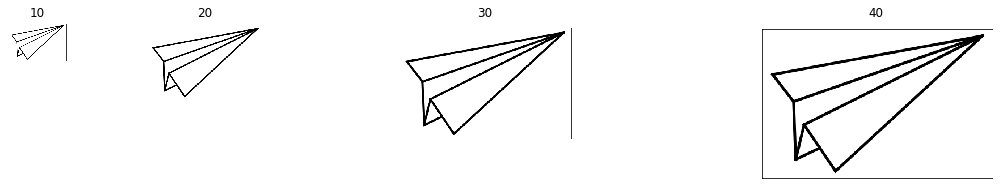

In [5]:
luigi.build(
    [
       AirplaneGallery(), 
            ],
    local_scheduler=True
)

You might have noticed that we only specified the end task `AirplaneGallery`, not the flow of tasks. The dependency tree in works backwards to determine which earlier taks are needed.

## Parameters

* Each task take any number of parameters
* Each unique combination of parmaeters should produce a unique and determinable output (idempotency)
* Parameters can be implied from earlier taks using the `@requires` decorator

In [37]:
from luigi.util import requires

class Airplane(luigi.Task):
    """
    Create a plot of an airplane
    
    Methods
    --------
    requires()
        What prerequiste tasks does this need
    
    run()
        Running the code for the task
    
    output()
        Define output  that defines the task as complete
        
    Attributes
    ------------
    color: luigi.Parameter
        parametrs can be used to parameterise tasks
        each combination of parameters is considred a unique task
    """
    color = luigi.Parameter(default='k')
    
    def run(self):
        plot_airplane(filename=os.path.join(f"img/plane_{self.color}.png"),
                     color=self.color)
        
    def output(self):
        return luigi.LocalTarget(os.path.join(f"img/plane_{self.color}.png"))
        
# This decorator replaces definign the requires function in the code
# it also carries parameters with it
@requires(Airplane)
class AirplaneGallery(luigi.Task):
    """
    Create a plot of an airplane
    
    Methods
    --------
    run()
        Display a gallery of airplanes
    
    output()
        Output that defines the task as complete

    Inherited Parmaters
    --------------------
    color: luigi.Parameter
        color of planes
    """
    
    def run(self):
        
        img = mpimg.imread(f"img/plane_{self.color}.png")
        
        store_scale = 3.0
        
        plt.figure(figsize=(20,10))
        gridspec.GridSpec(200,100)

        scales = [10,20,30,40]
            
        offset = 0
        for scale in scales:
            plt.subplot2grid((200,100),(0, offset), colspan=scale, rowspan=int(scale*1.5))
            plt.imshow(img)
            plt.axis('off')
            plt.title(scale)
            offset += scale 
     
        plt.savefig(f"img/gallery_{self.color}.png")
        
    def output(self):
        return luigi.LocalTarget(f"img/gallery_{self.color}.png")

DEBUG: Checking if AirplaneGallery(color=m) is complete
DEBUG: Checking if Airplane(color=m) is complete
INFO: Informed scheduler that task   AirplaneGallery_m_2a013631c4   has status   PENDING
INFO: Informed scheduler that task   Airplane_m_2a013631c4   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 2
INFO: [pid 22646] Worker Worker(salt=560629691, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) running   Airplane(color=m)


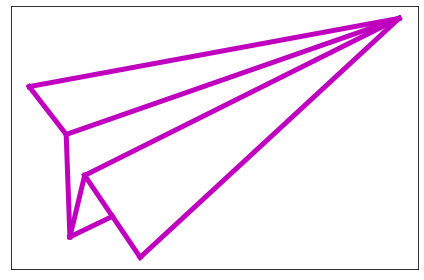

INFO: [pid 22646] Worker Worker(salt=560629691, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) done      Airplane(color=m)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   Airplane_m_2a013631c4   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 22646] Worker Worker(salt=560629691, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) running   AirplaneGallery(color=m)
INFO: [pid 22646] Worker Worker(salt=560629691, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) done      AirplaneGallery(color=m)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   AirplaneGallery_m_2a013631c4   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=560629691, workers=1, host=nelse003-MS-7996, username=nelse003, pid=22646) was stopped. Shutting down Kee

True

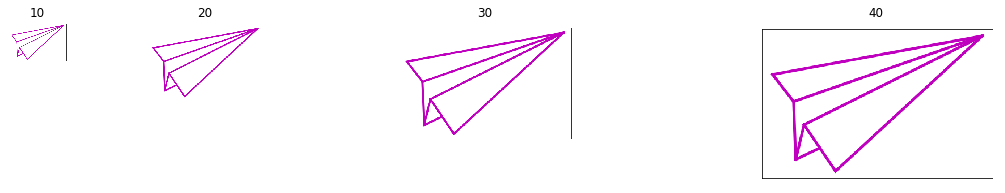

In [40]:
luigi.build(
    [
       AirplaneGallery(color='m'), 
            ],
    local_scheduler=False
)


## Distributed task scheduling

* Luigi is not inherently distributed.
* Luigi can have many workers, but these are contained to a single node
* As i wanted to handle many tasks on the Diamond Light Source cluster, I used the clusters SGE qsub system alongisde luigi

In [ ]:
# Effectively defines a queue watcher
class QsubTask(luigi.Task):
    """
    Base class for Qsub Tasks
    """
    submitted = False

    def get_queue_jobs(self):

        # run 'qstat -r'
        output_queue = run_qstat()

        queue_jobs = []
        # Turn qstat output into list of jobs
        for line in output_queue:
            if "Full jobname" in line:
                jobname = line.split()[-1]
                queue_jobs.append(jobname)

        return queue_jobs


class QsubMinimaPdb(QsubTask):
    """
    Task for submission of turning exhasutive minima csv into pdb
    """
    input_pdb = luigi.Parameter()
    output_pdb = luigi.Parameter()
    csv_name = luigi.Parameter()

    def output(self):
        return luigi.LocalTarget(self.output_pdb)

    def run(self):

        minima_py = "/dls/science/groups/i04-1/elliot-dev/" \
                    "Work/exhaustive_search/exhaustive/utils/minima.py"

        queue_jobs = self.get_queue_jobs()

        cmd = "ccp4-python {minima_py} --input_pdb {input_pdb} " \
              "--output_pdb {output_pdb} --csv_name {csv_name}".format(
            minima_py=minima_py,
            input_pdb=self.input_pdb,
            output_pdb=self.output_pdb,
            csv_name=self.csv_name)

        if not os.path.isfile(self.output_pdb):

            job = os.path.join(os.path.dirname(self.output_pdb), "minima.csh")
            job_file = os.path.basename(str(job))

            with open(job,'w') as f:
                f.write("source {ccp4}\n".format(ccp4=Path().ccp4))
                f.write(cmd)

                
            ###############################################
            #  Submits job if not in queue watcher
            #  Wait until job complete
            ################################################
            if job_file not in queue_jobs and not self.submitted:
                submit_job(job_directory=os.path.dirname(self.output_pdb),
                            job_script=job_file)
                self.submitted = True

                print(
                    "The job had no output, and was not found to be running "
                    "in the queue. The job has been submitted. "
                )

            # Run until job complete
            time.sleep(5)
            queue_jobs = self.get_queue_jobs()
            if job_file in queue_jobs:
                time.sleep(30)
                self.run()
                
                
class BatchExhaustiveMinimaToPdb(luigi.Task):
    """
    Run an batch of convert exhasutive minima to pdb tasks

    Methods
    ------------
    output()
        csv path to a csv summarising failures and
        sucesses of jobs submitted to qsub

    requires()
        batch of QsubMinimaPdbTasks

    """
    output_csv = luigi.Parameter()
    refinement_folder = luigi.Parameter()
    overwrite = luigi.Parameter(default=False)

    def output(self):
        return luigi.LocalTarget(self.output_csv)

    def requires(self):
        """
        Batch of QSubEdstats task

        Returns
        -------

        """
        minima_tasks=[]
        # Loop over folders for refienemnts
        for xtal_folder in os.listdir(self.refinement_folder):

            pdb = None

            fol = os.path.join(self.refinement_folder, xtal_folder)

            output_pdb = os.path.join(fol,"refine.pdb")
            csv_name = os.path.join(fol,"exhaustive_search.csv")

            if not self.overwrite and os.path.exists(csv_name):
                continue

            if os.path.isdir(fol):
                for f in os.listdir(fol):
                    if f == "input.pdb":
                        tmp_pdb = os.path.join(fol, "input.pdb")
                        if os.path.exists(tmp_pdb):
                            pdb = tmp_pdb

            # for when looping over crystal folders,
            # may be extra files
            else:
                continue
            # If pdb and mtz are not found
            if pdb is None:
                continue

            task = QsubMinimaPdb(input_pdb=pdb,
                                 output_pdb=output_pdb,
                                 csv_name=csv_name)

            # If QsubMinma task already completed
            if os.path.exists(output_pdb):
                continue

                
            ########################
            # Returns a lsit of tasks 
            ########################
            minima_tasks.append(task)

        return minima_tasks

## My Luigi pipeline

* I have used luigi to schedule refinement tasks.

* https://github.com/nelse003/parse_xchemdb

* It is ideal as different refinemnts have differing requirements, and can utilise different pre-processing and post processing tasks.


## Alternatives

* Airflow is an alternative based on directed acyclic graph mode, and is developed by Airbnb: https://towardsdatascience.com/data-pipelines-luigi-airflow-everything-you-need-to-know-18dc741449b7


### Exploiting Parallelism

* [Dask](https://dask.org/) allows distributed parallelism with easy syntax for tasks that can be carried out with libraries such as numpy, pandas and scikit learn.
    * More useful in cases where most of program have tasks that scale well across nodes
    * Can be run on a single machine to better utilise multi-core
    * Implements Bags, Arrays, dataframes for data that can be larger than your RAM
    * Also has a UI interface for managing tasks
    * Natively distributed
    * https://towardsdatascience.com/why-every-data-scientist-should-use-dask-81b2b850e15b



##  More Information

* [Luigi docs](https://luigi.readthedocs.io/en/stable/)